# **Deep Learning Course**

## **Loss Functions and Multilayer Perceptrons (MLP)**

---

### **Student Information:**

- **Name:** Muhammad Erfan Bagherinejad
- **Student Number:** 402200359

---

### **Assignment Overview**

In this notebook, we will explore various loss functions used in neural networks, with a specific focus on their role in training **Multilayer Perceptrons (MLPs)**. By the end of this notebook, you will have a deeper understanding of:
- Types of loss functions
- How loss functions affect the training process
- The relationship between loss functions and model optimization in MLPs

---

### **Table of Contents**

1. Introduction to Loss Functions
2. Types of Loss Functions
3. Multilayer Perceptrons (MLP)
4. Implementing Loss Functions in MLP
5. Conclusion

---



# 1.Introduction to Loss Functions

In deep learning, **loss functions** play a crucial role in training models by quantifying the difference between the predicted outputs and the actual targets. Selecting the appropriate loss function is essential for the success of your model. In this assay, we will explore various loss functions available in PyTorch, understand their theoretical backgrounds, and provide you with a scaffolded class to experiment with these loss functions.

Before begining, let's train a simle MLP model using the **L1Loss** function. We'll return to this model later to experiment with different loss functions. We'll start by importing the necessary libraries and defining the model architecture.

First things first, let's talk about **L1Loss**.

### 1. L1Loss (`torch.nn.L1Loss`)
- **Description:** Also known as Mean Absolute Error (MAE), L1Loss computes the average absolute difference between the predicted values and the target values.
- **Use Case:** Suitable for regression tasks where robustness to outliers is desired.

Here is the mathematical formulation of L1Loss:
\begin{equation}
\text{L1Loss} = \frac{1}{n} \sum_{i=1}^{n} |y_{\text{pred}_i} - y_{\text{true}_i}|
\end{equation}

Let's implement a simple MLP model using the L1Loss function.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.nn import L1Loss, MSELoss
import matplotlib.pyplot as plt
# Don't be courious about Adam, it's just a fancy name for a fancy optimization algorithm

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(21)  # Set a fixed seed for reproducibility

Here, we'll define a class called `SimpleMLP` that inherits from `nn.Module`. This class can have multiple layers, and we'll use the `nn.Sequential` module to define the layers of the model. The model will have the following architecture:

In [12]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers=1, last_layer_activation_fn=None):
        super(SimpleMLP, self).__init__()

        # Define the layers of the MLP
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dim, output_dim))
        if last_layer_activation_fn is not None:
            layers.append(last_layer_activation_fn)

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Define the forward pass of the MLP
        return self.model(x)

Now, let's define a class called `SimpleMLP_Loss` that has the following architecture:

In [13]:
class SimpleMLPTrainer:
    def __init__(self, model, criterion, optimizer, activation_fn=None):
        criterion_nn = {
            'mseloss': nn.MSELoss(),
            'l1loss': nn.L1Loss(),
            'nllloss': nn.NLLLoss(),
            'crossentropyloss': nn.CrossEntropyLoss(),
            'kldiveloss': nn.KLDivLoss()
        }
        activation_fn_nn = {
            'sigmoid': nn.Sigmoid(),
            'softmax': nn.Softmax(dim=1),
            'logsoftmax': nn.LogSoftmax(dim=1),
            'relu': nn.ReLU(),
        }
        self.model = model
        self.criterion = criterion_nn.get(criterion, None)
        self.optimizer = optimizer
        self.activation_fn = activation_fn_nn.get(activation_fn, None)
    
    def train(self, train_loader, num_epochs):
        total_batches = len(train_loader) * num_epochs  # Total steps for tqdm
        training_losses = []  # To store average loss per epoch

        pbar = tqdm(total=total_batches, desc="Training Progress", leave=True)

        for epoch in range(num_epochs):
            self.model.train()
            epoch_loss = 0

            for inputs, targets in train_loader:                
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                if self.activation_fn is not None:
                    outputs = self.activation_fn(outputs)
                
                # Conditions for every Loss:   
                if isinstance(self.criterion, (nn.MSELoss, nn.L1Loss)):
                    outputs = outputs.squeeze(dim=1)
                elif isinstance(self.criterion, nn.NLLLoss) and isinstance(self.activation_fn, nn.ReLU):
                    outputs = outputs.squeeze(dim=1)
                    targets = targets.long()
                elif isinstance(self.criterion, nn.NLLLoss) and isinstance(self.activation_fn, nn.LogSoftmax):
                    targets = targets.long()
                elif isinstance(self.criterion, nn.CrossEntropyLoss):
                    targets = targets.long()
                   
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
                pbar.update(1)

            avg_loss = epoch_loss / len(train_loader)
            training_losses.append(avg_loss)

        pbar.close()

        # Print all epoch losses at the end of the training process
        for epoch, loss in enumerate(training_losses, 1):
            print(f'Epoch {epoch}/{num_epochs}, Training Loss: {loss:.4f}')
            epochs = list(range(1, len(training_losses) + 1))

        # Create the plot
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, training_losses, marker='o', linestyle='-', color='b')
        plt.title('Training Loss vs Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Training Loss')
        plt.xticks(epochs, rotation=90)  # Rotate x-ticks to vertical
        plt.grid()
        plt.tight_layout()  # Adjust layout to prevent clipping of tick labels
        plt.show()

        return training_losses

    def evaluate(self, val_loader):
        self.model.eval()
        val_loss = 0 
        correct = 0 
        total = 0 

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = self.model(inputs)
                if self.activation_fn is not None:
                    outputs = self.activation_fn(outputs)
                    
                # Conditions for every Loss:
                if isinstance(self.criterion, (nn.MSELoss, nn.L1Loss)):
                    outputs = outputs.squeeze(dim=1)
                    predicted = (outputs.float() > 0.5).float()
                elif isinstance(self.criterion, nn.NLLLoss) and isinstance(self.activation_fn, nn.ReLU):
                    outputs = outputs.squeeze(dim=1)
                    targets = targets.long()
                    predicted = (outputs.float() > 0.5).float()
                elif isinstance(self.criterion, nn.NLLLoss) and isinstance(self.activation_fn, nn.LogSoftmax):
                    targets = targets.long()    
                    predicted = torch.argmax(outputs, dim=1).float()
                elif isinstance(self.criterion, nn.CrossEntropyLoss):
                    targets = targets.long()
                    predicted = torch.argmax(nn.functional.softmax(outputs, dim=1), dim=1)
                elif isinstance(self.criterion, nn.KLDivLoss):
                    if isinstance(self.activation_fn, nn.ReLU):
                        loss = self.criterion(outputs, targets)
                        val_loss += loss.item()
                        predicted = (torch.argmax(outputs, dim=1).float() > 0.5).float()
                        targets = torch.argmax(targets, dim=1).float() 
                    else:
                        loss = self.criterion(outputs, targets)
                        val_loss += loss.item() 
                        predicted = torch.argmax(outputs, dim=1).float()
                        targets = torch.argmax(targets, dim=1).float() 
                
                if not isinstance(self.criterion, nn.KLDivLoss):
                    loss = self.criterion(outputs, targets)
                    val_loss += loss.item()                
                
                correct += (predicted.view(-1) == targets.view(-1)).sum().item()
                total += targets.size(0)

        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct / total

        print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
        return avg_val_loss, accuracy

Next, lets test our model using the L1Loss function. You'll use <span style="color:red">*Titanic Dataset*</span> to train the model.


In [14]:
# Load dataset
train_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(train_url)

# Preprocessing
data = data[['Pclass', 'Sex', 'Age', 'Fare', 'Survived']].dropna()
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

# Create following function for preparing data, train and evaluate the model with different loss function
def train_evaluate_model_with_different_loss(
    data,
    criterion,
    input_dim=4,
    hidden_dim=64,
    output_dim=1,
    num_hidden_layers=2,
    lr=0.0001,
    num_epochs=150,
    random_seed=21,
    last_layer_activation_fn='relu'
):
    # Set random seed for reproducibility
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)

    # Separate features and target
    X = data[['Pclass', 'Sex', 'Age', 'Fare']].values
    y = data['Survived'].values

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # One-hot encode target if kl divergence is the criterion of neural network
    if criterion == 'kldiveloss':
        encoder = OneHotEncoder(sparse_output=False)
        y = encoder.fit_transform(y.reshape(-1, 1))

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Create a TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Split data into training and validation sets
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for train and validation sets
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialize the model
    model = SimpleMLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_hidden_layers=num_hidden_layers)
    print(model)

    # Initialize the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize the trainer
    trainer = SimpleMLPTrainer(model, criterion, optimizer, last_layer_activation_fn)

    # Train the model
    training_losses = trainer.train(train_loader, num_epochs)

    # Evaluate the model
    test_loss, accuracy = trainer.evaluate(test_loader)

    return model, training_losses, test_loss, accuracy


<div style="text-align: center;"> <span style="color:red; font-size: 26px; font-weight: bold;">Let's train!</span> </div>

SimpleMLP(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


Training Progress: 100%|██████████| 900/900 [00:02<00:00, 317.89it/s]


Epoch 1/50, Training Loss: 0.4217
Epoch 2/50, Training Loss: 0.3900
Epoch 3/50, Training Loss: 0.3645
Epoch 4/50, Training Loss: 0.3413
Epoch 5/50, Training Loss: 0.3154
Epoch 6/50, Training Loss: 0.2909
Epoch 7/50, Training Loss: 0.2623
Epoch 8/50, Training Loss: 0.2431
Epoch 9/50, Training Loss: 0.2369
Epoch 10/50, Training Loss: 0.2319
Epoch 11/50, Training Loss: 0.2305
Epoch 12/50, Training Loss: 0.2274
Epoch 13/50, Training Loss: 0.2258
Epoch 14/50, Training Loss: 0.2252
Epoch 15/50, Training Loss: 0.2257
Epoch 16/50, Training Loss: 0.2233
Epoch 17/50, Training Loss: 0.2224
Epoch 18/50, Training Loss: 0.2218
Epoch 19/50, Training Loss: 0.2212
Epoch 20/50, Training Loss: 0.2209
Epoch 21/50, Training Loss: 0.2221
Epoch 22/50, Training Loss: 0.2214
Epoch 23/50, Training Loss: 0.2211
Epoch 24/50, Training Loss: 0.2195
Epoch 25/50, Training Loss: 0.2200
Epoch 26/50, Training Loss: 0.2191
Epoch 27/50, Training Loss: 0.2189
Epoch 28/50, Training Loss: 0.2180
Epoch 29/50, Training Loss: 0

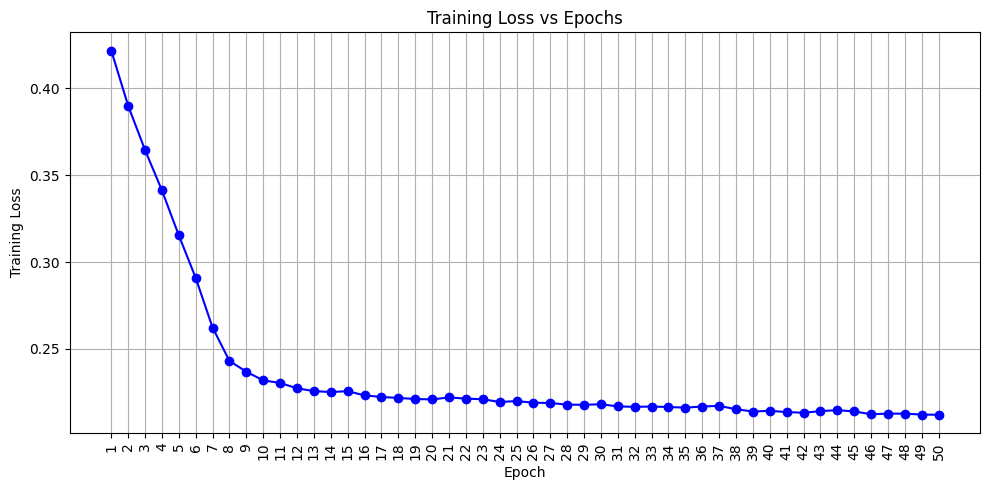

Validation Loss: 0.1983, Accuracy: 79.72%


In [15]:
# Train and evaluate the model with L1Loss and ReLU as activation function
model, training_losses, test_loss, accuracy = train_evaluate_model_with_different_loss(
    data=data,
    criterion='l1loss',
    input_dim=4,
    hidden_dim=64,
    output_dim=1,
    num_hidden_layers=2,
    lr=0.0002,
    num_epochs=50,
    random_seed=21,
    last_layer_activation_fn=None
)

---
# 2. Types of Loss Functions

PyTorch offers a variety of built-in loss functions tailored for different types of problems, such as regression, classification, and more. Below, we discuss several commonly used loss functions, their theoretical foundations, and typical use cases.

### 2. MSELoss (`torch.nn.MSELoss`)
- **Description:** Mean Squared Error (MSE) calculates the average of the squares of the differences between predicted and target values.
- **Use Case:** Commonly used in regression problems where larger errors are significantly penalized.

Here is boring math stuff for MSE:
\begin{equation}
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}
\end{equation}

<span style="color:red; font-size: 18px; font-weight: bold;">Warning:</span> Don't forget to reinitialize the model before experimenting with different loss functions.

SimpleMLP(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


Training Progress:   0%|          | 0/900 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 900/900 [00:02<00:00, 344.80it/s]


Epoch 1/50, Training Loss: 0.3550
Epoch 2/50, Training Loss: 0.3108
Epoch 3/50, Training Loss: 0.2767
Epoch 4/50, Training Loss: 0.2503
Epoch 5/50, Training Loss: 0.2282
Epoch 6/50, Training Loss: 0.2118
Epoch 7/50, Training Loss: 0.1970
Epoch 8/50, Training Loss: 0.1846
Epoch 9/50, Training Loss: 0.1744
Epoch 10/50, Training Loss: 0.1656
Epoch 11/50, Training Loss: 0.1601
Epoch 12/50, Training Loss: 0.1540
Epoch 13/50, Training Loss: 0.1504
Epoch 14/50, Training Loss: 0.1476
Epoch 15/50, Training Loss: 0.1456
Epoch 16/50, Training Loss: 0.1428
Epoch 17/50, Training Loss: 0.1414
Epoch 18/50, Training Loss: 0.1403
Epoch 19/50, Training Loss: 0.1390
Epoch 20/50, Training Loss: 0.1384
Epoch 21/50, Training Loss: 0.1388
Epoch 22/50, Training Loss: 0.1376
Epoch 23/50, Training Loss: 0.1372
Epoch 24/50, Training Loss: 0.1360
Epoch 25/50, Training Loss: 0.1363
Epoch 26/50, Training Loss: 0.1352
Epoch 27/50, Training Loss: 0.1355
Epoch 28/50, Training Loss: 0.1347
Epoch 29/50, Training Loss: 0

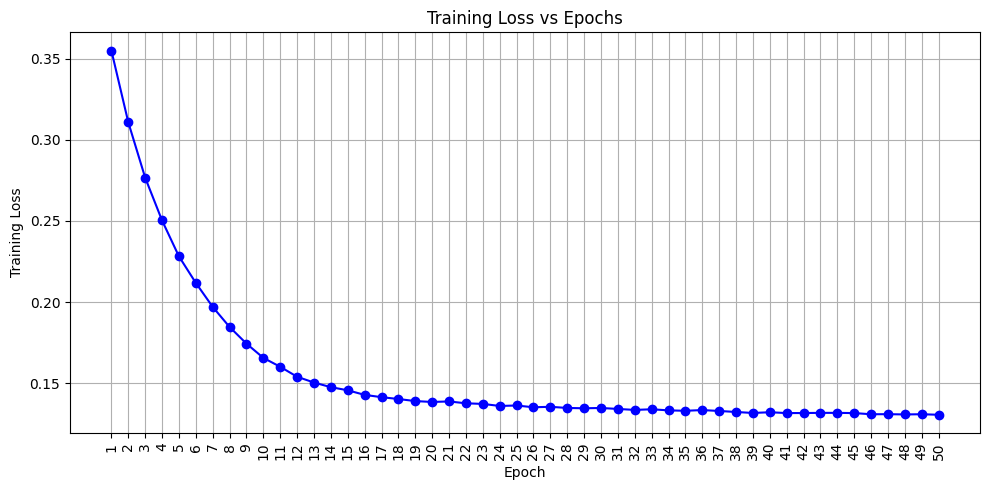

Validation Loss: 0.1374, Accuracy: 81.82%


In [16]:
from torch.nn import MSELoss

# Train and evaluate the model
model, training_losses, test_loss, accuracy = train_evaluate_model_with_different_loss(
    data=data,
    criterion='mseloss',
    input_dim=4,
    hidden_dim=64,
    output_dim=1,
    num_hidden_layers=2,
    lr=0.0001,
    num_epochs=50,
    random_seed=21,
    last_layer_activation_fn=None
)

### 3. NLLLoss (`torch.nn.NLLLoss`)
- **Description:** Negative Log-Likelihood Loss measures the likelihood of the target class under the predicted probability distribution.
- **Use Case:** Typically used in multi-class classification tasks, especially when combined with `log_softmax` activation.

Here is the mathematical formulation of NLLLoss:
\begin{equation}
\text{NLLLoss} = -\frac{1}{n} \sum_{i=1}^{n} \log(y_{i})
\end{equation}

I hope you note the logarithm in the formula. It's important!

Why?

The logarithm in the NLLLoss formula is critical because it directly reflects the confidence of the model in its predictions. When we calculate the negative log of the probability assigned to the true class, it penalizes low probabilities more heavily and rewards high probabilities with a smaller loss. This logarithmic scaling is important because it helps the loss function increase exponentially when the model is less certain about the correct class, pushing it to learn more accurate, high-confidence predictions for the true class.

Additionally, it's important to note that when using NLLLoss, employing a ReLU activation function for the output layer is not suitable. Since the logarithm of values greater than 1 is positive, the loss would become negative if the output yi
​
  (from ReLU) is greater than 1. This is problematic because a negative loss can lead to confusion in the training process. Instead, a softmax activation function is typically used before applying NLLLoss, as it outputs probabilities that are constrained between 0 and 1, ensuring that the input to the logarithm is always valid.

Without the logarithm, the loss wouldn't penalize low probabilities for the true class as significantly, which could lead to a model that isn't as "confident" in its correct classifications.

In this part, run your training with Relu at last layer. <span style="color:red; font-weight: bold;">Discuss </span> and explain the difference between the results of the two models. Find a proper solution to the problem.

SimpleMLP(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


Training Progress: 100%|██████████| 900/900 [00:02<00:00, 343.41it/s]


Epoch 1/50, Training Loss: -0.1262
Epoch 2/50, Training Loss: -0.2163
Epoch 3/50, Training Loss: -0.3189
Epoch 4/50, Training Loss: -0.4116
Epoch 5/50, Training Loss: -0.5250
Epoch 6/50, Training Loss: -0.6773
Epoch 7/50, Training Loss: -0.7605
Epoch 8/50, Training Loss: -0.9659
Epoch 9/50, Training Loss: -1.1168
Epoch 10/50, Training Loss: -1.2839
Epoch 11/50, Training Loss: -1.6878
Epoch 12/50, Training Loss: -1.7229
Epoch 13/50, Training Loss: -2.1353
Epoch 14/50, Training Loss: -2.5804
Epoch 15/50, Training Loss: -2.8345
Epoch 16/50, Training Loss: -3.4148
Epoch 17/50, Training Loss: -3.8065
Epoch 18/50, Training Loss: -5.0534
Epoch 19/50, Training Loss: -5.1379
Epoch 20/50, Training Loss: -6.3122
Epoch 21/50, Training Loss: -6.4825
Epoch 22/50, Training Loss: -7.3694
Epoch 23/50, Training Loss: -7.9260
Epoch 24/50, Training Loss: -9.5041
Epoch 25/50, Training Loss: -9.9562
Epoch 26/50, Training Loss: -12.2653
Epoch 27/50, Training Loss: -12.2590
Epoch 28/50, Training Loss: -13.759

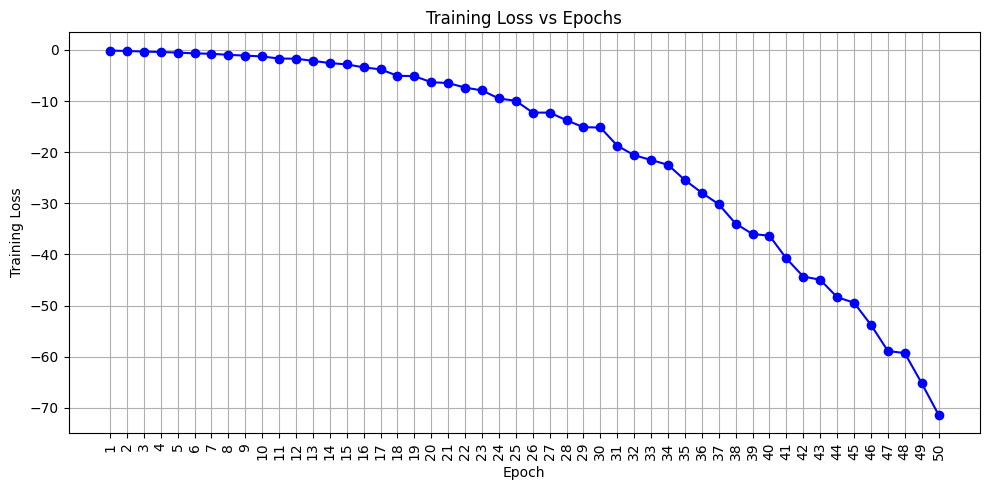

Validation Loss: -63.5256, Accuracy: 34.27%


In [17]:
# Run with relu activation function
from torch.nn import NLLLoss
# Train and evaluate the model
model, training_losses, test_loss, accuracy = train_evaluate_model_with_different_loss(
    data=data,
    criterion='nllloss',
    input_dim=4,
    hidden_dim=64,
    output_dim=1,
    num_hidden_layers=2,
    lr=0.0002,
    num_epochs=50,
    random_seed=21,
    last_layer_activation_fn='relu'
)

SimpleMLP(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


Training Progress: 100%|██████████| 900/900 [00:02<00:00, 311.20it/s]


Epoch 1/50, Training Loss: 0.6699
Epoch 2/50, Training Loss: 0.6045
Epoch 3/50, Training Loss: 0.5509
Epoch 4/50, Training Loss: 0.5093
Epoch 5/50, Training Loss: 0.4772
Epoch 6/50, Training Loss: 0.4594
Epoch 7/50, Training Loss: 0.4489
Epoch 8/50, Training Loss: 0.4410
Epoch 9/50, Training Loss: 0.4346
Epoch 10/50, Training Loss: 0.4312
Epoch 11/50, Training Loss: 0.4293
Epoch 12/50, Training Loss: 0.4265
Epoch 13/50, Training Loss: 0.4246
Epoch 14/50, Training Loss: 0.4224
Epoch 15/50, Training Loss: 0.4191
Epoch 16/50, Training Loss: 0.4186
Epoch 17/50, Training Loss: 0.4179
Epoch 18/50, Training Loss: 0.4165
Epoch 19/50, Training Loss: 0.4157
Epoch 20/50, Training Loss: 0.4151
Epoch 21/50, Training Loss: 0.4131
Epoch 22/50, Training Loss: 0.4117
Epoch 23/50, Training Loss: 0.4109
Epoch 24/50, Training Loss: 0.4114
Epoch 25/50, Training Loss: 0.4090
Epoch 26/50, Training Loss: 0.4097
Epoch 27/50, Training Loss: 0.4064
Epoch 28/50, Training Loss: 0.4062
Epoch 29/50, Training Loss: 0

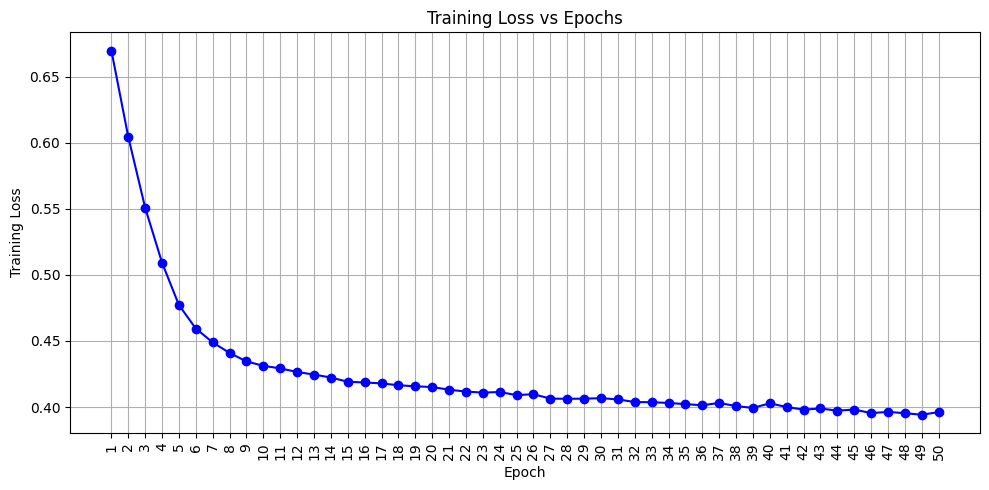

Validation Loss: 0.4451, Accuracy: 81.82%


In [18]:
# Run with LogSoftMax activation function
# Train and evaluate the model
model, training_losses, test_loss, accuracy = train_evaluate_model_with_different_loss(
    data=data,
    criterion='nllloss',
    input_dim=4,
    hidden_dim=128,
    output_dim=2,
    num_hidden_layers=2,
    lr=0.0002,
    num_epochs=50,
    random_seed=21,
    last_layer_activation_fn='logsoftmax'
)

Your reason for your choice:

### Discussion and Explanation of the Difference Between Models Using ReLU and Log-Softmax for NLLLoss

#### 1. **Using ReLU vs. Log-Softmax in the Final Layer**

   - **Log-Softmax**: Typically, NLLLoss is combined with a `log_softmax` activation function, which converts raw scores (logits) from the model’s final layer into a log-probability distribution over the classes. Log-Softmax ensures that each output node represents the log-probability of each class, which aligns with the input requirements of NLLLoss.

   - **ReLU**: ReLU is a commonly used activation function but is **not suitable as a final activation layer** for NLLLoss because it outputs unbounded non-negative values rather than probabilities. ReLU introduces two main problems:
     1. **No Probability Distribution**: ReLU doesn't create a probability distribution, meaning it doesn’t provide class probabilities that sum to 1, which NLLLoss expects.
     2. **Possible Zero Values**: ReLU can produce zero outputs, and taking the log of zero is undefined, causing errors or inaccurate loss values.

#### 2. **Observed Difference Between the Models**

When using ReLU in the final layer:
   - The model likely fails to converge properly, as NLLLoss cannot interpret the unbounded and non-normalized outputs effectively.
   - Training may result in **unstable gradients or even NaN values** if ReLU outputs zeros, making it impossible to calculate the log for NLLLoss.

When using Log-Softmax:
   - The model outputs log-probabilities, making it compatible with NLLLoss.
   - Training is stable, as the negative log of the output is a meaningful penalty for incorrect predictions.
   - The model learns to focus on the correct class with a smoother gradient, improving convergence and accuracy.

#### 3. **Solution to the Problem**

To resolve this issue, **replace ReLU with Log-Softmax in the final layer** if we are using NLLLoss. This change will ensure the model outputs log-probabilities, allowing NLLLoss to compute a meaningful loss and guide training effectively.


### 4. CrossEntropyLoss (`torch.nn.CrossEntropyLoss`)
- **Description:** Combines `LogSoftmax` and `NLLLoss` in one single class. It computes the cross-entropy loss between the target and the output logits.
- **Use Case:** Widely used for multi-class classification problems.

The mathematical formulation of CrossEntropyLoss is as follows:
\begin{equation}
  \text{CrossEntropy}(y, \hat{y}) = - \sum_{i=1}^{C} y_i \log\left(\frac{e^{\hat{y}_i}}{\sum_{j=1}^{C} e^{\hat{y}_j}}\right)
\end{equation}
  where:
  - \( C \) is the number of classes,
  - \( y_i \) is a one-hot encoded target vector (or a scalar class label),
  - \( \hat{y}_i \) represents the logits (unnormalized model outputs) for each class.
  
  In practice, `torch.nn.CrossEntropyLoss` expects raw logits as input and internally applies the softmax function to convert the logits into probabilities, followed by the negative log-likelihood computation.

- **Background:** Cross-entropy measures the difference between the true distribution \( y \) and the predicted distribution \( \hat{y} \). The function minimizes the negative log-probability assigned to the correct class, effectively penalizing predictions that deviate from the true class, making it a standard choice for classification tasks in deep learning.

Now, let's implement a class called `SimpleMLP_Loss` that has the following architecture:


SimpleMLP(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


Training Progress:   0%|          | 0/900 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 900/900 [00:02<00:00, 362.78it/s]


Epoch 1/50, Training Loss: 0.6614
Epoch 2/50, Training Loss: 0.6323
Epoch 3/50, Training Loss: 0.6059
Epoch 4/50, Training Loss: 0.5804
Epoch 5/50, Training Loss: 0.5557
Epoch 6/50, Training Loss: 0.5337
Epoch 7/50, Training Loss: 0.5129
Epoch 8/50, Training Loss: 0.4938
Epoch 9/50, Training Loss: 0.4777
Epoch 10/50, Training Loss: 0.4670
Epoch 11/50, Training Loss: 0.4563
Epoch 12/50, Training Loss: 0.4502
Epoch 13/50, Training Loss: 0.4441
Epoch 14/50, Training Loss: 0.4409
Epoch 15/50, Training Loss: 0.4369
Epoch 16/50, Training Loss: 0.4327
Epoch 17/50, Training Loss: 0.4328
Epoch 18/50, Training Loss: 0.4315
Epoch 19/50, Training Loss: 0.4282
Epoch 20/50, Training Loss: 0.4288
Epoch 21/50, Training Loss: 0.4273
Epoch 22/50, Training Loss: 0.4241
Epoch 23/50, Training Loss: 0.4266
Epoch 24/50, Training Loss: 0.4230
Epoch 25/50, Training Loss: 0.4230
Epoch 26/50, Training Loss: 0.4204
Epoch 27/50, Training Loss: 0.4205
Epoch 28/50, Training Loss: 0.4191
Epoch 29/50, Training Loss: 0

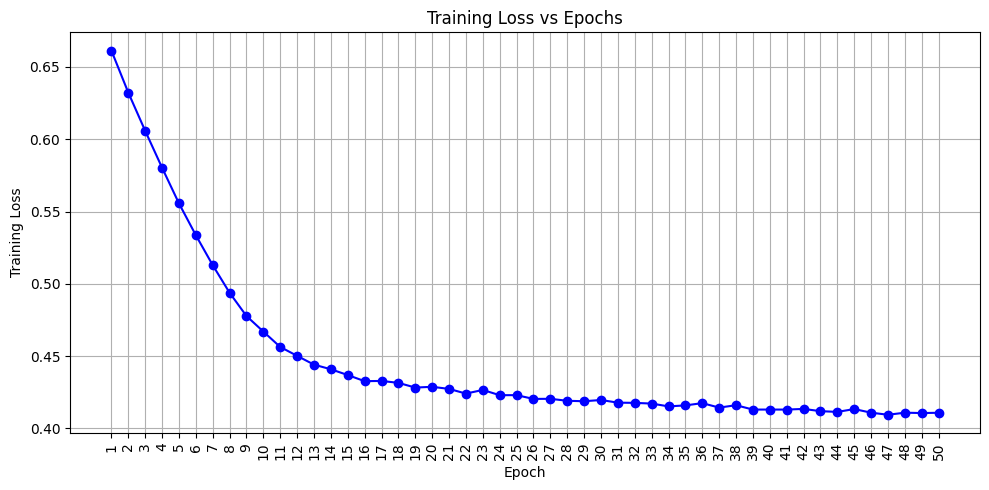

Validation Loss: 0.4464, Accuracy: 81.82%


In [19]:
# Run model without last layer activation function with Cross Entropy Loss
model, training_losses, test_loss, accuracy = train_evaluate_model_with_different_loss(
    data=data,
    criterion='crossentropyloss',
    input_dim=4,
    hidden_dim=64,
    output_dim=2,
    num_hidden_layers=2,
    lr=0.0002,
    num_epochs=50,
    random_seed=21,
    last_layer_activation_fn=None
)


### 5. KLDivLoss (`torch.nn.KLDivLoss`)
- **Description:** Kullback-Leibler Divergence Loss measures how one probability distribution diverges from a second, reference distribution. Unlike other loss functions that focus on classification, KL divergence specifically compares the relative entropy between two distributions. It quantifies the information loss when using the predicted distribution to approximate the true distribution.

- **Mathematical Function:**
\begin{equation}
  \text{KL}(P \parallel Q) = \sum_{i=1}^{C} P(i) \left( \log P(i) - \log Q(i) \right)
\end{equation}
  where:
  - \( P \) is the target (true) probability distribution,
  - \( Q \) is the predicted distribution (often the output of `log_softmax`),
  - \( C \) is the number of classes.

  KL divergence is always non-negative, and it equals zero if the two distributions are identical. The loss function expects the model's output to be in the form of log-probabilities (using `log_softmax`) and compares this against a target probability distribution, which is typically a normalized distribution (using softmax).

- **Use Case:** KLDivLoss is frequently used in:
  - **Variational Autoencoders (VAEs):** In VAEs, KL divergence is used to measure how much the learned latent space distribution deviates from a prior distribution (often Gaussian).
  - **Knowledge Distillation:** In teacher-student models, KL divergence is used to transfer the "soft" knowledge from a teacher model to a student model by comparing their output probability distributions.
  - **Reinforcement Learning:** It can be used to update policies while minimizing the divergence from a previous policy.

- **Background:** Kullback-Leibler divergence, a core concept in information theory, measures the inefficiency of assuming the predicted distribution \( Q \) when the true distribution is \( P \). It is asymmetric, meaning that \( KL(P \parallel Q) \neq KL(Q \parallel P) \), so the direction of the comparison matters.

Again, in this part, run your training with Relu at last layer. <span style="color:red; font-weight: bold;">Discuss </span> and explain the difference between the results of the two models. Find a proper solution to the problem.


SimpleMLP(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


Training Progress:   0%|          | 0/900 [00:00<?, ?it/s]C:\Users\moham\AppData\Roaming\Python\Python312\site-packages\torch\nn\functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Training Progress: 100%|██████████| 900/900 [00:02<00:00, 359.97it/s]


Epoch 1/50, Training Loss: -0.0532
Epoch 2/50, Training Loss: -0.0930
Epoch 3/50, Training Loss: -0.1354
Epoch 4/50, Training Loss: -0.1860
Epoch 5/50, Training Loss: -0.2458
Epoch 6/50, Training Loss: -0.3378
Epoch 7/50, Training Loss: -0.4776
Epoch 8/50, Training Loss: -0.6469
Epoch 9/50, Training Loss: -0.8466
Epoch 10/50, Training Loss: -1.0709
Epoch 11/50, Training Loss: -1.3388
Epoch 12/50, Training Loss: -1.6404
Epoch 13/50, Training Loss: -1.9903
Epoch 14/50, Training Loss: -2.3821
Epoch 15/50, Training Loss: -2.8384
Epoch 16/50, Training Loss: -3.3380
Epoch 17/50, Training Loss: -3.9128
Epoch 18/50, Training Loss: -4.5417
Epoch 19/50, Training Loss: -5.2485
Epoch 20/50, Training Loss: -6.0313
Epoch 21/50, Training Loss: -6.8868
Epoch 22/50, Training Loss: -7.8473
Epoch 23/50, Training Loss: -8.8860
Epoch 24/50, Training Loss: -10.0524
Epoch 25/50, Training Loss: -11.2906
Epoch 26/50, Training Loss: -12.6686
Epoch 27/50, Training Loss: -14.1259
Epoch 28/50, Training Loss: -15.7

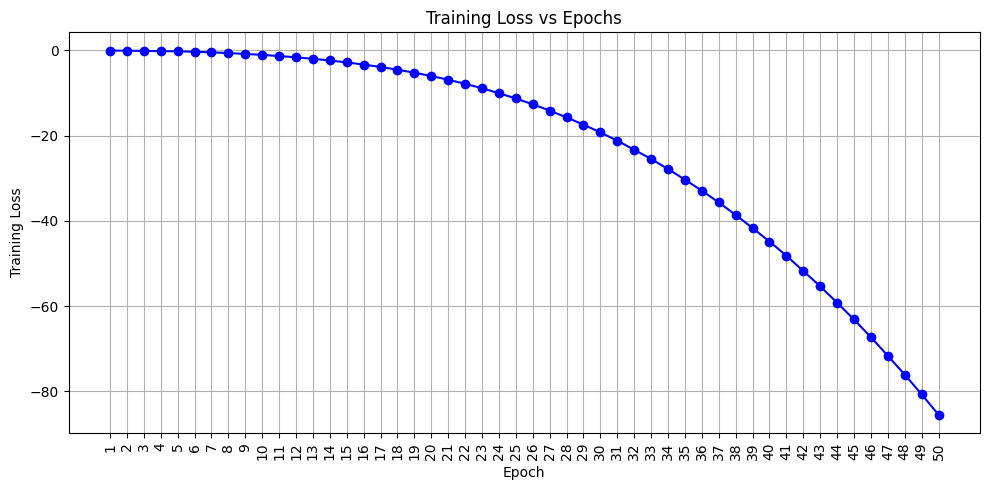

Validation Loss: -86.1684, Accuracy: 65.73%


In [20]:
# Run with relu activation function
model, training_losses, test_loss, accuracy = train_evaluate_model_with_different_loss(
    data=data,
    criterion='kldiveloss',
    input_dim=4,
    hidden_dim=64,
    output_dim=2,
    num_hidden_layers=2,
    lr=0.0002,
    num_epochs=50,
    random_seed=21,
    last_layer_activation_fn='relu'
)

SimpleMLP(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


Training Progress:   0%|          | 0/900 [00:00<?, ?it/s]C:\Users\moham\AppData\Roaming\Python\Python312\site-packages\torch\nn\functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Training Progress: 100%|██████████| 900/900 [00:02<00:00, 378.48it/s]


Epoch 1/50, Training Loss: 0.3307
Epoch 2/50, Training Loss: 0.3162
Epoch 3/50, Training Loss: 0.3029
Epoch 4/50, Training Loss: 0.2902
Epoch 5/50, Training Loss: 0.2779
Epoch 6/50, Training Loss: 0.2668
Epoch 7/50, Training Loss: 0.2565
Epoch 8/50, Training Loss: 0.2469
Epoch 9/50, Training Loss: 0.2389
Epoch 10/50, Training Loss: 0.2335
Epoch 11/50, Training Loss: 0.2282
Epoch 12/50, Training Loss: 0.2251
Epoch 13/50, Training Loss: 0.2220
Epoch 14/50, Training Loss: 0.2205
Epoch 15/50, Training Loss: 0.2185
Epoch 16/50, Training Loss: 0.2163
Epoch 17/50, Training Loss: 0.2164
Epoch 18/50, Training Loss: 0.2157
Epoch 19/50, Training Loss: 0.2141
Epoch 20/50, Training Loss: 0.2144
Epoch 21/50, Training Loss: 0.2137
Epoch 22/50, Training Loss: 0.2120
Epoch 23/50, Training Loss: 0.2133
Epoch 24/50, Training Loss: 0.2115
Epoch 25/50, Training Loss: 0.2115
Epoch 26/50, Training Loss: 0.2102
Epoch 27/50, Training Loss: 0.2102
Epoch 28/50, Training Loss: 0.2095
Epoch 29/50, Training Loss: 0

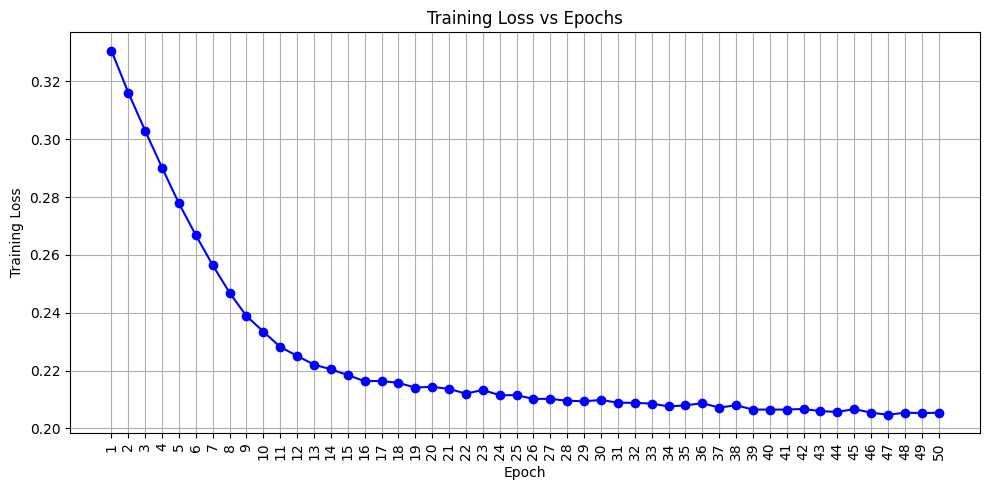

Validation Loss: 0.2232, Accuracy: 81.82%


In [21]:
# Run with logsoftmax activation function
model, training_losses, test_loss, accuracy = train_evaluate_model_with_different_loss(
    data=data,
    criterion='kldiveloss',
    input_dim=4,
    hidden_dim=64,
    output_dim=2,
    num_hidden_layers=2,
    lr=0.0002,
    num_epochs=50,
    random_seed=21,
    last_layer_activation_fn='logsoftmax'
)

Your reason for your choice:

<div>

### LogSoftmax
1. **Probability Distribution**: `log_softmax` transforms the raw output scores (logits) into a probability distribution over classes. It ensures that the outputs sum to 1, which is crucial for interpreting them as probabilities.

2. **Numerical Stability**: By applying the logarithm after the softmax function, `log_softmax` maintains numerical stability during the computation of probabilities, especially with large logits. This is important for avoiding issues with underflow or overflow.

3. **Compatibility with KLDivLoss**: `KLDivLoss` is designed to measure the divergence between two probability distributions. Since `log_softmax` outputs a log-probability, it is directly compatible with `KLDivLoss`, which expects log probabilities for one of its inputs.

4. **Interpretability**: Using `log_softmax` allows for a clearer interpretation of the model outputs in terms of probabilities, making it easier to understand the model's confidence in its predictions.

### ReLU
1. **Non-Normalized Outputs**: `ReLU` (Rectified Linear Unit) outputs non-negative values but does not ensure that they sum to 1 or form a proper probability distribution. This makes it unsuitable for tasks that require probability estimates.

2. **Not Suitable for KL Divergence**: Since `KLDivLoss` expects one of its inputs to be a probability distribution (or log-probabilities), using `ReLU` would lead to incorrect calculations. The outputs would not represent valid probabilities, which could lead to misleading results during training.

3. **Use Cases**: While `ReLU` is effective in many contexts (e.g., hidden layers in neural networks), it is not the right choice for output layers when the task requires a probabilistic interpretation, such as in classification tasks where KL divergence is calculated.

For tasks involving `KLDivLoss`, `log_softmax` is the appropriate choice because it produces a proper probability distribution that is numerically stable and directly compatible with the loss function. In contrast, `ReLU` is not suitable for this purpose, as it does not provide probabilities and can lead to incorrect loss calculations.
</div>

### 6. CosineEmbeddingLoss (`torch.nn.CosineEmbeddingLoss`)
- **Description:** Measures the cosine similarity between two input tensors, `x1` and `x2`, and computes the loss based on a label `y` that indicates whether the tensors should be similar (`y = 1`) or dissimilar (`y = -1`). Cosine similarity focuses on the angle between vectors, disregarding their magnitude.

- **Mathematical Function:**
\begin{equation}
  \text{CosineEmbeddingLoss}(x1, x2, y) =
  \begin{cases}
  1 - \cos(x_1, x_2), & \text{if } y = 1 \\
  \max(0, \cos(x_1, x_2) - \text{margin}), & \text{if } y = -1
  \end{cases}
\end{equation}
  where $ \cos(x_1, x_2) $ is the cosine similarity between the two vectors, and `margin` is a threshold that determines how dissimilar the vectors should be.

- **Use Case:** Commonly used in tasks like face verification, image similarity, and other scenarios where the relative orientation of vectors (angle) is more important than their length, such as in embeddings and metric learning.

- **Background:** Cosine similarity compares the directional alignment of vectors, making it ideal for high-dimensional data where the magnitude may not be as informative. This loss is particularly useful when training models to learn meaningful embeddings that capture semantic similarity.

You'll become more fimiliar with this loss function in future.

---

# Regularization in Machine Learning

## Introduction

Regularization is a fundamental technique in machine learning that helps prevent overfitting by adding a penalty to the loss function. This penalty discourages the model from becoming too complex, ensuring better generalization to unseen data. In this notebook, you will explore the concepts of regularization, understand different types of regularization techniques, and apply them using Python's popular libraries.

## What is Regularization?

Regularization involves adding a regularization term to the loss function used to train machine learning models. This term imposes a constraint on the model's coefficients, effectively reducing their magnitude. By doing so, regularization helps in:

- **Preventing Overfitting:** Ensures the model does not become too tailored to the training data.
- **Improving Generalization:** Enhances the model's performance on new, unseen data.
- **Feature Selection:** Especially in L1 regularization, it can drive some coefficients to zero, effectively selecting important features.

## Types of Regularization

There are several types of regularization techniques, each imposing different constraints on the model's parameters:

### 1. L1 Regularization (Lasso)

L1 regularization adds the absolute value of the magnitude of coefficients as a penalty term to the loss function. It can lead to sparse models where some feature coefficients are exactly zero.

### 2. L2 Regularization (Ridge)

L2 regularization adds the squared magnitude of coefficients as a penalty term to the loss function. It tends to shrink the coefficients evenly but does not set them to zero.

### 3. Elastic Net

Elastic Net combines both L1 and L2 regularization penalties. It balances the benefits of both Lasso and Ridge methods, allowing for feature selection and coefficient shrinkage.

## Homework Time!
Import Iris dataset from sklearn.datasets and apply ridge regression with different alpha values. Then, create a gif that shows the changes of the classification boundary with respect to alpha values.

Import the libs that you need and start coding!

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from PIL import Image
from io import BytesIO
import imageio
import warnings


# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

Load the Iris dataset and select Setosa and Versicolor classes

In [23]:
# Load and Prepare the Iris Dataset
iris = load_iris()

# Convert to a DataFrame for easier manipulation
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['species'] = iris.target

# Map target values to species names for clarity
species_map = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}
df['species'] = df['species'].map(species_map)

# Filter to include only Setosa and Versicolor
df_binary = df[df['species'].isin(['Setosa', 'Versicolor'])]

# Select Sepal Length and Petal Length for features
X = df_binary[['sepal length (cm)', 'petal length (cm)']].values
y = df_binary['species'].map({'Setosa': 0, 'Versicolor': 1}).values  # Encode Setosa as 0, Versicolor as 1

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Summary of the data preparation
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (80, 2)
Testing data shape: (20, 2)


Define Function to Plot Decision Boundary

In [24]:
def plot_decision_boundary(model, X, y, alpha):
    
    # Define the grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict over the grid
    Z = model.predict(grid).reshape(xx.shape)

    # Create a figure
    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, levels=[-0.1, 0.1, 1.1], colors=['blue', 'red'])

    # Scatter plot of the training data
    scatter = ax.scatter(
        X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', s=50
    )

    # Title and labels
    ax.set_title(f'MLP Decision Boundary (alpha={alpha})')
    ax.set_xlabel('Sepal Length (standardized)')
    ax.set_ylabel('Petal Length (standardized)')

    # Remove axes for clarity
    ax.set_xticks([])
    ax.set_yticks([])

    # Tight layout
    plt.tight_layout()

    # Save the plot to a BytesIO object
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

Train MLP with Varying Alpha Values and Collect Images

In [25]:
def create_decision_boundary_gif(alpha_values, X_train, y_train, n_neurons):
    # List to store images
    images = []

    for idx, alpha in enumerate(alpha_values):
        print(f"Processing alpha={alpha:.4f} ({idx + 1}/{len(alpha_values)})")

        # Create and train the MLP
        mlp = MLPClassifier(
            hidden_layer_sizes=(n_neurons,),
            alpha=alpha,
            max_iter=1000,
            random_state=10,
            activation='identity'
        )
        mlp.fit(X_train, y_train)

        # Plot decision boundary and get the image
        img = plot_decision_boundary(mlp, X_train, y_train, alpha)
        images.append(img)

    # Save the images as a GIF
    gif_filename = 'mlp_classification_boundaries_example.gif'
    images[0].save(
        gif_filename,
        save_all=True,
        append_images=images[1:],
        duration=200,
        loop=0
    )

    print(f"GIF saved as '{gif_filename}'")

    # return the gif
    return gif_filename

## RUN

In [26]:
alpha_values = np.logspace(-4, 4, 20)  # From 10^-4 to 10^1
n_neurons = 25  # Define the number of neurons in the hidden layer

# Create the decision boundary GIF
gif_filename = create_decision_boundary_gif(alpha_values, X_train, y_train, n_neurons)
print(f"GIF saved at {gif_filename}")

Processing alpha=0.0001 (1/20)
Processing alpha=0.0003 (2/20)
Processing alpha=0.0007 (3/20)
Processing alpha=0.0018 (4/20)
Processing alpha=0.0048 (5/20)
Processing alpha=0.0127 (6/20)
Processing alpha=0.0336 (7/20)
Processing alpha=0.0886 (8/20)
Processing alpha=0.2336 (9/20)
Processing alpha=0.6158 (10/20)
Processing alpha=1.6238 (11/20)
Processing alpha=4.2813 (12/20)
Processing alpha=11.2884 (13/20)
Processing alpha=29.7635 (14/20)
Processing alpha=78.4760 (15/20)
Processing alpha=206.9138 (16/20)
Processing alpha=545.5595 (17/20)
Processing alpha=1438.4499 (18/20)
Processing alpha=3792.6902 (19/20)
Processing alpha=10000.0000 (20/20)
GIF saved as 'mlp_classification_boundaries_example.gif'
GIF saved at mlp_classification_boundaries_example.gif


Your gif should look like this:

<div style="text-align: center;">

### **Multilayer Perceptron Classification Boundaries**

![Classification Boundaries](mlp_classification_boundaries_example.gif)

*Figure 1: Demonstration of classification boundaries created by a Multilayer Perceptron (MLP) model.*

</div>

